# Fast scientific code with Python


Author: [Pierre Ablin](https://www.pierreablin.com). 


Based on an idea by [Alexandre Gramfort](http://alexandre.gramfort.net/).





**Dependencies:**

For this notebook, we will need numba, cython, numexpr and memory_profiler. numba evolves quickly, so the most recent version is the best. To install all those:

` $ pip install ...`



To get the latest versions, running anaconda:

` $ conda update ...`





Python is the go-to langage when it comes to quickly translating an idea into code. It is very easy to write and read. The drawback is that most natural operations come with a lot of tests, conversion, type checking, etc... which renders scientific coding with the standard python library extremely slow. Luckily, there are a lot of tools and libraries to make Python code almost a fast as native fortran/C in most cases.

Is Python truly slow? Not if well optimized. Take the scikit-learn library, which contains many machine learning algorithm. It is written in Python, yet it contains the fastest implementation available of several massively used algorithms.

As a side note: a great way to produce a scientific code in Python is first to write a working algorithm that might be slow. The important part is that it works. Then, profile it (i.e. time each of its component, or check the memory load if thats a problem too) to see which part can be improved and which part does not really have to be changed. It sounds obvious, but it is almost always useless to try to optimize a function that only makes for 5% of the total timing of the algorithm.


With that in mind, parts of the algorithms that are not critical can be left in beautiful and clean python code while the rest has to be optimized.



Let us try to solve a simple problem. Consider the Wallis product $P_n = 2 \prod_{i=1}^{n}\frac{4i^2}{4i^2 - 1}$ which converges to $\pi$. We are going to try to make its computation as fast as possible for large $n$.

A very naive approach is the following:

In [1]:
def wallis1(n):
    out = 1.
    for i in range(1, n):
        out *= float((4 * i ** 2)) / float((4 * i ** 2 - 1))
    return 2. * out

wallis1(10000)

3.1415141108281714

## Vectorize
The previous method is slow, because of the loop. The operations carried inside the loop are extremely slow and repeated many times.
The most natural way to overcome this problem in python is to vectorize using numpy.

In [2]:
import numpy as np

def wallis2(n):
    int_list = np.arange(1, n)
    return 2 * np.prod( 4 * int_list ** 2 / (4 * int_list ** 2 - 1.))


%timeit wallis1(10000)
%timeit wallis2(10000)

100 loops, best of 3: 4.11 ms per loop
The slowest run took 4.31 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 90.3 µs per loop


We can see that this code is orders of magnitude faster than the previous one. Vectorizing is extremely important in scientific computing as vectors/matrices/tensors are by far the most common data structure encountered. Consequently, some very efficient libraries exist to work with vectors. This explains why numpy is at the core of scientific computing.

Now, we can make this code faster by avoiding useless computations. Indeed, the product `4 * int_list ** 2` only has to be computed once.

In [3]:
def wallis3(n):
    tmp = 4 * np.arange(1, n) ** 2
    return 2 * np.prod( tmp / (tmp - 1.))

%timeit wallis2(10000)
%timeit wallis3(10000)

10000 loops, best of 3: 81.9 µs per loop
10000 loops, best of 3: 66.6 µs per loop


Another gain factor comes from the useless memory copies performed in the above call. Once `int_list` is computed, there is no need to keep it in memory. Further, when doing `tmp = 4 * int_list ** 2`, numpy takes int_list, creates an intermediate copy, then squares it. Then it takes that copy, and multiplies it by 4. These copies are unecessary. The way to efficiently manage memory and avoid unecessary copies is to use `+=`, `-=`, etc... You should also avoid as much as possible type conversion.

In [4]:
def wallis4(n):
    tmp = np.arange(1, n, dtype=float)
    tmp *= tmp  # Legend has it that it is the fastest way to square
    tmp *= 4.
    tmp /= tmp - 1.
    return 2. * np.prod(tmp)

%timeit wallis3(10000)
%timeit wallis4(10000)

10000 loops, best of 3: 70.8 µs per loop
10000 loops, best of 3: 42.8 µs per loop


We have gained a little bit (a factor two compared to the naive numpy version). 

## Cython

Now, it is not always the case that operations can be vectorized as easily. Sometimes you just cannot avoid the loops. We can use Cython to write code that is going to be compiled in C.

In [5]:
%load_ext cython

In cython, you have to type and define each variable that you are going to use beforehand, which is going to render our code a bit less readable. If cython does not understand an instruction, it will fall back to a python instruction, which might render everything incredibly slow. To debug, you can use the command --annotate which will hilight the lines which interact wit python (yellow inside of a loop means slow).

In [6]:
%%cython
import cython

@cython.cdivision(True)
def wallis5(int n):
    cdef double out = 2.
    cdef double tmp
    cdef int i
    for i in range(1, n):
        tmp = 4. * (i * i)
        out *= tmp / (tmp - 1.)
    return out

In [7]:
%timeit wallis4(10000)
%timeit wallis5(10000)

The slowest run took 4.03 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 43.4 µs per loop
100000 loops, best of 3: 13.9 µs per loop


Cython is more efficient than numpy for this problem.

An important advantage of the cython implementation is its memory load!
To have a quick check at the memory load of a program, we can use `memory_profiler`.

In [8]:
%load_ext memory_profiler

In [9]:
%memit wallis4(1000000)
%memit wallis5(1000000)

peak memory: 82.59 MiB, increment: 15.39 MiB
peak memory: 67.39 MiB, increment: 0.10 MiB


Cython basically allows you to do most things you would want to do in C, and supports most functions of the standard library. 

## Numba

Now, there is an incredible tool called Numba which is getting better and better, and aims at accelerating the code even more than Cython, without having these anoying variable declarations on top of the program. Using it is super easy: you take your naive approach, put @autojit on top and voilà.

In [10]:
from numba import autojit


@autojit
def wallis6(n):
    out = 2.
    for i in range(1, n):
        tmp = 4 * i**2
        out *= tmp / (tmp - 1.)
    return out

%timeit wallis4(10000)
%timeit wallis6(10000)

10000 loops, best of 3: 43.1 µs per loop
The slowest run took 7473.22 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 12.8 µs per loop


Now let us compare all these methods:

Timing for Numpy 1 ...
Timing for Numpy 2 ...
Timing for Numpy 3 ...
Timing for Cython ...
Timing for Numba ...


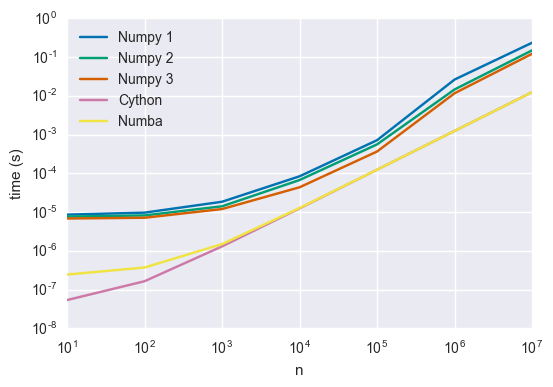

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()
seaborn.set_palette("colorblind")

functions = [wallis2, wallis3, wallis4, wallis5, wallis6]
names = ['Numpy 1', 'Numpy 2', 'Numpy 3', 'Cython', 'Numba']
n_list = np.logspace(1, 7, num=7, dtype=int)


plt.figure()
for function, name in zip(functions, names):
    print('Timing for %s ...' % name)
    times =[]
    for n in n_list:
        t = %timeit -oq function(n)
        times.append(t.best)
    plt.loglog(n_list, times, label=name)
plt.xlabel('n')
plt.ylabel('time (s)')
plt.legend(loc='upper left')
plt.show()

The results are pretty clear, on this problem, Cython and Numba are the clear winners. Numba is also much easier to use but lacks some features of cython.

# Array processing

The previous example made Numba really shine. The reality is sometimes subtler.

Let us consider the simple case of computing the mean of a function of a signal $x(t)$ of length $T$. That is, we want to compute $\frac{1}{T}\sum_{t=1}^T f(x(t))$. Let us take for $f$ a slightly complicated function: $$f(x) = \cos(e^{- \rvert x \lvert })$$


### Numpy

In [12]:
def function1(x):
    return np.mean(np.cos(np.exp(-np.abs(x))))

def function2(x):
    tmp = -np.abs(x)
    np.exp(tmp, out=tmp)
    np.cos(tmp, out=tmp)
    return np.mean(tmp)

### Cython

In [13]:
%%cython
from libc.math cimport exp, cos

def function3(double[:] x):
    cdef double out = 0.
    cdef int T = x.shape[0]
    cdef int i
    for i in range(T):
        out += cos(exp(-abs(x[i])))
    return out / float(T)


### Numba

In [14]:
@autojit(nopython=True)
def function4(x):
    out = 0.
    T = x.shape[0]
    for i in range(x.shape[0]):
        out += np.cos(np.exp(-np.abs(x[i])))
    return out / float(T)

### Numexpr

Numexpr is a library that performs efficient expression evaluation. It is really great to compute complicated functions of large arrays.

In [15]:
import numexpr as ne

def function5(x):
    tmp = ne.evaluate('cos(exp(-abs(x)))')
    return np.mean(tmp)

def function6(x):
    return ne.evaluate('sum(cos(exp(-abs(x))))') / float(len(x))

### Comparison

Timing for Numpy ...
Timing for Numpy2 ...
Timing for Cython ...
Timing for Numba ...
Timing for Numexpr ...
Timing for Numexpr2 ...


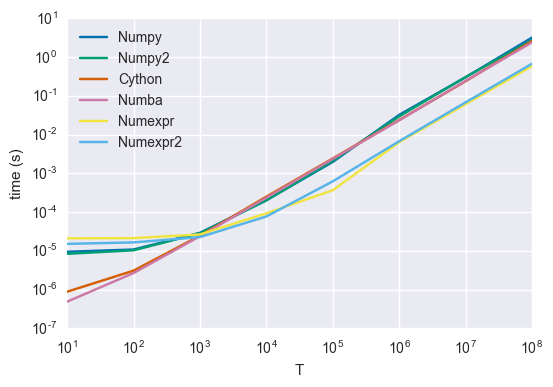

In [16]:
functions = [function1, function2, function3, function4, function5, function6]
names = ['Numpy', 'Numpy2', 'Cython', 'Numba', 'Numexpr', 'Numexpr2']
T_list = np.logspace(1, 8, num=8, dtype=int)
x_list = [np.random.randn(T) for T in T_list]

plt.figure()
for function, name in zip(functions, names):
    print('Timing for %s ...' % name)
    times = []
    for x in x_list:
        t = %timeit -oq function(x)
        times.append(t.best)
    plt.loglog(T_list, times, label=name)
plt.xlabel('T')
plt.ylabel('time (s)')
plt.legend(loc='upper left')
plt.show()

Numexpr is generally the go to tool when it comes to large array processing. Unfortunatelly, the built in 'sum' function is not as fast as expected, it does not use paralelization, which explains why using `np.mean` is faster for large T.